In [2]:
from nltk import ne_chunk, pos_tag, word_tokenize
import nltk
nltk.download('maxent_ne_chunker')
nltk.download('words')
from datasets import load_dataset
from collections import Counter, defaultdict

from matplotlib import pyplot as plt
import numpy as np

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Bruger\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Bruger\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
plt.style.use('dark_background')

In [5]:
data = load_dataset('GonzaloA/fake_news')

Repo card metadata block was not found. Setting CardData to empty.


In [56]:
np.random.seed(100)

print(true[np.random.randint(1, len(true))]['text'])
print()
print(true[np.random.randint(1, len(true))]['text'])
print()
print(true[np.random.randint(1, len(true))]['text'])
print()
print(true[np.random.randint(1, len(true))]['text'])
print()
print(true[np.random.randint(1, len(true))]['text'])

HOUSTON (Reuters) - NuStar Energy LP has shut down operations at its oil terminal in the Caribbean island of St. Eustatius ahead of the arrival of Hurricane Irma, the U.S. firm said in a statement on Tuesday. The Statia terminal has capacity to store up to 13.03 million barrels of crude and refined products and has six mooring locations to service oil tankers.  We have activated our hurricane response plan and will continue to monitor the storm to determine our next course of action,  the company said. 

ANKARA (Reuters) - Turkey’s foreign ministry on Monday summoned the U.S. embassy undersecretary and called for an end to a dispute between the two countries, Turkish foreign ministry sources said, after the NATO allies suspended visa services.  The sources said the undersecretary was told the visa suspension move caused “unnecessary tensions” and should be reversed. They said Turkey’s foreign ministry undersecretary also spoke by phone with the U.S. ambassador on Sunday. In a move sign

In [57]:
np.random.seed(100)

print(fake[np.random.randint(1, len(fake))]['text'])
print()
print(fake[np.random.randint(1, len(fake))]['text'])
print()
print(fake[np.random.randint(1, len(fake))]['text'])
print()
print(fake[np.random.randint(1, len(fake))]['text'])
print()
print(fake[np.random.randint(1, len(fake))]['text'])

Here s a mom who knows how to raise her children 

Just days after the death of his own son in combat, Lt Gen John Kelly eulogized two other sons in an unforgettable manner:Two years ago when I was the Commander of all U.S. and Iraqi forces, in fact, the 22nd of April 2008, two Marine infantry battalions, 1/9  The Walking Dead,  and 2/8 were switching out in Ramadi. One battalion in the closing days of their deployment going home very soon, the other just starting its seven-month combat tour.Two Marines, Corporal Jonathan Yale and Lance Corporal Jordan Haerter, 22 and 20 years old respectively, one from each battalion, were assuming the watch together at the entrance gate of an outpost that contained a makeshift barracks housing 50 Marines.The same broken down ramshackle building was also home to 100 Iraqi police, also my men and our allies in the fight against the terrorists in Ramadi, a city until recently the most dangerous city on earth and owned by Al Qaeda. Yale was a dirt poor m

In [6]:
def compute_ratios(first: list, other: list) -> dict:
    '''
    returns the frequency for each element in first divided by its frequency in other
        - meant to show which elements are overrepresented in first compared to other
    '''
    first_counts = Counter(first)
    other_counts = Counter(other)

    ratios = {}

    for item in first_counts:
        if item in other_counts:
            ratios[item] = first_counts[item] / other_counts[item]
        else:
            # to avoid division by zero, pretends items absent in other occur once instead
            ratios[item] = first_counts[item] 

    return ratios

In [7]:
# splits up data by label
fake = []
true = []
for article in data['train']:
    if article['label'] == 1: # label == true
        true.append(article)
    else:# label == fake
        fake.append(article)


# merges and tokenizes the text of the fake/non-fake news
true_combined = ' '.join([article['text'] for article in true])
fake_combined = ' '.join([article['text'] for article in fake])
true_tokens = word_tokenize(true_combined)
fake_tokens = word_tokenize(fake_combined)

# computes token frequency in fake news / frequency in non-fake news (and vice versa) and sorts by ratio
true_ratios = compute_ratios(true_tokens, fake_tokens)
fake_ratios = compute_ratios(fake_tokens, true_tokens)
true_ratios_sorted = sorted(list(true_ratios.items()), key=lambda x: x[1], reverse=True)
fake_ratios_sorted = sorted(list(fake_ratios.items()), key=lambda x: x[1], reverse=True)

In [8]:
# prepares token ratios for plotting

# only plots top 10 highest ratios
n_tokens = 10

x_true = [token for token, _  in true_ratios_sorted[:n_tokens]]
x_fake = [token for token, _  in fake_ratios_sorted[:n_tokens]]
x_true.reverse()
x_fake.reverse()

y_true = [ratio for _, ratio in true_ratios_sorted[:n_tokens]]
y_fake = [ratio for _, ratio in fake_ratios_sorted[:n_tokens]]
y_true.reverse()
y_fake.reverse()

In [32]:
# samples article to save compute time on the following
size = 400
np.random.seed(100)
fake_sample = np.random.choice(fake, size=size)
true_sample = np.random.choice(true, size=size)

# does NER on non-fake news, storing all named entities in list
true_NE = []
true_combined = ' '.join([article['text'] for article in true_sample])
tags = pos_tag(word_tokenize(true_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        true_NE.append(' '.join([word[0] for word in chunk]))

# does NER on fake news, storing all named entities in list
fake_NE = []
fake_combined = ' '.join([article['text'] for article in fake_sample])
tags = pos_tag(word_tokenize(fake_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        fake_NE.append(' '.join([word[0] for word in chunk]))


# computes named entity frequency in fake news / frequency in non-fake news (and vice versa) and sorts by ratio
true_ratios_NE = compute_ratios(true_NE, fake_NE)
fake_ratios_NE = compute_ratios(fake_NE, true_NE)
true_ratios_sorted_NE = sorted(list(true_ratios_NE.items()), key=lambda x: x[1], reverse=True)
fake_ratios_sorted_NE = sorted(list(fake_ratios_NE.items()), key=lambda x: x[1], reverse=True)

In [33]:
# prepares named entity ratios for plotting

# only plots top 10 highest ratios
n_entities = 10

x_true_NE = [entities for entities, _  in true_ratios_sorted_NE[:n_entities]]
x_fake_NE = [entities for entities, _  in fake_ratios_sorted_NE[:n_entities]]
x_true_NE.reverse()
x_fake_NE.reverse()

y_true_NE = [ratio for _, ratio in true_ratios_sorted_NE[:n_entities]]
y_fake_NE = [ratio for _, ratio in fake_ratios_sorted_NE[:n_entities]]
y_true_NE.reverse()
y_fake_NE.reverse()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_35792\1697913897.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


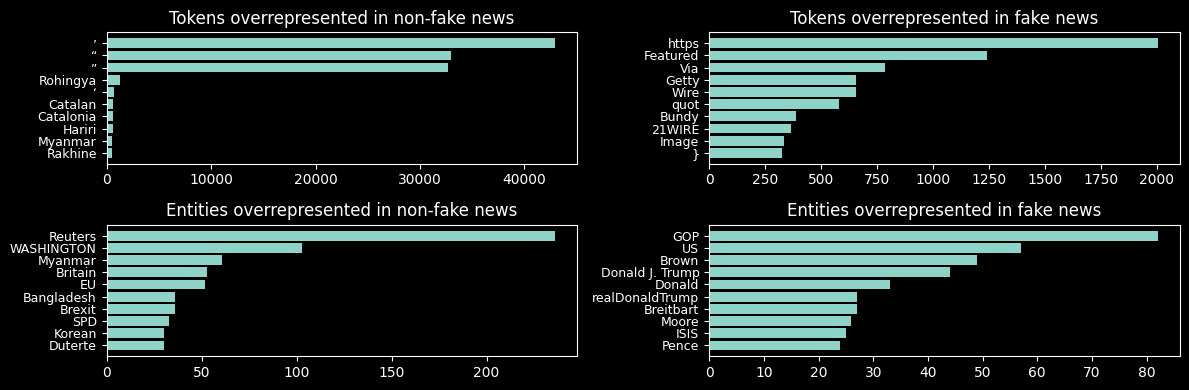

In [34]:
# plots all the ratios
fig, axs = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

axs = axs.flatten()

axs[0].barh(x_true, y_true)
axs[0].set_title('Tokens overrepresented in non-fake news')
axs[0].tick_params('y', labelsize=9)

axs[1].barh(x_fake, y_fake)
axs[1].set_title('Tokens overrepresented in fake news')
axs[1].tick_params('y', labelsize=9)

axs[2].barh(x_true_NE, y_true_NE)
axs[2].set_title('Named Entities overrepresented in non-fake news')
axs[2].tick_params('y', labelsize=9)

axs[3].barh(x_fake_NE, y_fake_NE)
axs[3].set_title('Named Entities overrepresented in fake news')
axs[3].tick_params('y', labelsize=9)

fig.tight_layout()
fig.savefig('figs/overrepresented.png', dpi=300)
fig.show()

In [ ]:
#with open('fake_tokens.txt', 'a') as f:
#    for token in sorted_:
#        f.write(f'{token[0]}, {token[1][0]}, {token[1][1][:10]}\n')

In [1]:
# ------- splits up data by label and stores index --------
fake = []
true = []

for i, article in enumerate(data['train']):
    
    # saving index for further analysis
    info = {'text': article['text'], 'index': i}

    if article['label'] == 0: # label == fake
        fake.append(info)

    else: # label == true
        true.append(info)


# --------- tokenizes the text of the fake news and counts occurrences ----------- 
fake_counts = defaultdict(lambda: {'count': 0, 'articles': []})

for info in fake:
    text = info['text']
    index = info['index'] # stores document index for future analysis
    tokens = word_tokenize(text)

    for token in tokens:
        fake_counts[token]['count'] += 1
        fake_counts[token]['articles'].append(index)


# -------- tokenizes the text of non-fake news and counts occurrences -----------
true_combined = ' '.join([article['text'] for article in true])
true_tokens = word_tokenize(true_combined)
true_amounts = Counter(true_tokens)


# --------- computes token frequency in fake news / frequency in non-fake news --------
fake_tf = {}

for token in fake_counts:
    count = fake_counts[token]['count']
    articles = fake_counts[token]['articles']
    if token in true_amounts:
        fake_tf[token] = {'freq': count / true_amounts[token], 
                          'articles': articles}
    else:
        # pretends tokens not appearing in true appear once (to avoid dividing by zero)
        fake_tf[token] = {'freq': count, 
                          'articles': articles}


# -------- sorts and prints tokens with highest value = most particular to fake news --------
sorted_ = sorted(list(fake_tf.items()), key=lambda x: x[1]['freq'], reverse=True)
for token, info in sorted_:
    print(token, info['freq'], info['articles'][:10])

NameError: name 'data' is not defined

In [ ]:
n_tokens = 10

x = [token for token, _  in sorted_[:20]]
y = [articles['freq'] for _, articles in sorted_[:20]]

x.reverse()
y.reverse()

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

ax.barh(x, y)
ax.set_xticklabels(y, rotation=50, rotation_mode='anchor', ha='right')

fig.show()

In [ ]:
size = 400
fake_sample = np.random.choice(fake, size=size)
true_sample = np.random.choice(true, size=size)

In [ ]:
fake_NE = []
fake_combined = ' '.join([article['text'] for article in fake_sample])
tags = pos_tag(word_tokenize(fake_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        fake_NE.append(' '.join([word[0] for word in chunk]))


true_NE = []
true_combined = ' '.join([article['text'] for article in true_sample])
tags = pos_tag(word_tokenize(true_combined))
chunks = ne_chunk(tags)
n_chunks = len(chunks)
for i, chunk in enumerate(chunks):
    if hasattr(chunk, 'label'):
        true_NE.append(' '.join([word[0] for word in chunk]))

In [ ]:
counts_fake_NE = Counter(fake_NE)
counts_true_NE = Counter(true_NE)

In [ ]:
fake_tf = {}

for token in counts_fake_NE:
    count = counts_fake_NE[token]
    if token in counts_true_NE:
        fake_tf[token] = count / counts_true_NE[token]
    else:
        # pretends tokens not appearing in true appear once (to avoid dividing by zero)
        fake_tf[token] = count


# -------- sorts and prints tokens with highest value = most particular to fake news --------
sorted_fake = sorted(list(fake_tf.items()), key=lambda x: x[1], reverse=True)
for token, count in sorted_:
    print(token, count)

In [ ]:
n_tokens = 20

x_fake = [token for token, _  in sorted_fake[:20]]
y_fake = [articles['freq'] for _, articles in sorted_fake[:20]]

x_fake.reverse()
y_fake.reverse()

fig, ax = plt.subplots(figsize=(12,12))

ax.barh(x_fake, y_fake)
ax.set_xticklabels(y_fake, rotation=50, rotation_mode='anchor', ha='right')

fig.show()

In [ ]:
true_tf = {}

for token in counts_true_NE:
    count = counts_true_NE[token]
    if token in counts_fake_NE:
        true_tf[token] = count / counts_fake_NE[token]
    else:
        # pretends tokens not appearing in fake appear once (to avoid dividing by zero)
        true_tf[token] = count


# -------- sorts and prints tokens with highest value = most particular to true news --------
sorted_ = sorted(list(true_tf.items()), key=lambda x: x[1], reverse=True)
for token, count in sorted_:
    print(token, count)

In [ ]:
n_tokens = 20

x_true = [token for token, _  in sorted_true[:20]]
y_true = [articles['freq'] for _, articles in sorted_true[:20]]

x_true.reverse()
y_true.reverse()

fig, ax = plt.subplots(figsize=(12,12))

ax.barh(x_true, y_true)
ax.set_xticklabels(y_true, rotation=50, rotation_mode='anchor', ha='right')

fig.show()

In [ ]:
counts_fake_NE